# Unleash the Ray - Grid Search

Let's revisit our grid search example but now with Ray

A lot of this code is going to be familiar as we already had our pipeline wraped in a function

In [1]:
%load_ext autoreload
%autoreload 2

from dependencies import *

Loading dependencies we have already seen...
Done...


In [2]:
import ray
from ray import tune

### Let's start Ray

In [3]:
ray.shutdown()
ray.init(num_cpus=10, num_gpus=0, include_webui=True)

2020-06-12 10:01:32,239	INFO resource_spec.py:204 -- Starting Ray with 33.74 GiB memory available for workers and up to 16.88 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-06-12 10:01:32,551	INFO services.py:1168 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '192.168.1.39',
 'raylet_ip_address': '192.168.1.39',
 'redis_address': '192.168.1.39:56003',
 'object_store_address': '/tmp/ray/session_2020-06-12_10-01-32_237557_127278/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-06-12_10-01-32_237557_127278/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-06-12_10-01-32_237557_127278'}

After initialisation the [Ray Dashboard](https://docs.ray.io/en/master/ray-dashboard.html) is available on the **webui_url** port

## Setup some raytune compatible training code

Very similar to before except now we have an end-to-end function

In [4]:

# differences from what we've seen before, this is an end to end training function
# where we are loading the dataset running our complete train and test loop whilst
# 
def e2e_simple_training(config):
    
    #threadsafe
    X, y = sklearn.datasets.load_breast_cancer(return_X_y=True)
    
    # chose your CV strategy
    splitter = StratifiedKFold(n_splits=5)
    
    # run k fold training and testing
    f1_scores = [] # keep hold of all individual scores
    for train_ind, test_ind in splitter.split(X, y):
        pipeline = make_pipeline(RobustScaler(),
                                  RandomForestClassifier(random_state=42))

        pipeline.set_params(**config)
        pipeline.fit(X[train_ind], y[train_ind])
        
        y_pred = pipeline.predict(X[test_ind])
        
        f1_scores.append(f1_score(y_pred, y[test_ind]))
    
    # use tunes reporter
    tune.track.log(mean_f1_score=np.array(f1_scores).mean(),
                std_f1_score=np.array(f1_scores).std(),
                # and we can actually add any metrics we like
                done=True)

Previously we had a param grid like this

```
param_grid = {
    'randomforestclassifier__n_estimators': [1,5,15,50,100],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__bootstrap': [True, False]
}
```

### TODO convert this to a set of ray search spaces

The Ray config object is freeform, we imprint our own structure.

However, tunable parameters need to be represented by tune distribution object >> [read the docs](https://docs.ray.io/en/latest/tune/api_docs/grid_random.html?highlight=tune.grid#random-distributions-api)

In [5]:
ray_tuning_config = {
    'randomforestclassifier__n_estimators': tune.grid_search([1,5,15,50,100])
}

In [6]:
analysis = tune.run(
                e2e_simple_training,
                config=ray_tuning_config,
                resources_per_trial=dict(cpu=1, gpu=0),
                local_dir="~/ray_results/grid_search")

Trial name,status,loc,randomforestclassifier__n_estimators
e2e_simple_training_00000,RUNNING,,1
e2e_simple_training_00001,PENDING,,5
e2e_simple_training_00002,PENDING,,15
e2e_simple_training_00003,PENDING,,50
e2e_simple_training_00004,PENDING,,100


(pid=127337) 2020-06-12 10:05:11,933	INFO trainable.py:217 -- Getting current IP.
Result for e2e_simple_training_00000:
  date: 2020-06-12_10-05-12
  done: true
  experiment_id: 82c57a9026914863b47dd2859458a307
  experiment_tag: 0_randomforestclassifier__n_estimators=1
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.9267873910127431
  node_ip: 192.168.1.39
  pid: 127337
  std_f1_score: 0.022471880003588674
  time_since_restore: 0.06892085075378418
  time_this_iter_s: 0.06892085075378418
  time_total_s: 0.06892085075378418
  timestamp: 1591952712
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00000'
  
(pid=127334) 2020-06-12 10:05:11,983	INFO trainable.py:217 -- Getting current IP.
(pid=127333) 2020-06-12 10:05:11,977	INFO trainable.py:217 -- Getting current IP.
(pid=127339) 2020-06-12 10:05:11,981	INFO trainable.py:217 -- Getting current IP.
(pid=127332) 2020-06-12 10:05:12,039	INFO trainable.py:217 -- Getting current IP.
Result for e2e_simple

Trial name,status,loc,randomforestclassifier__n_estimators,iter,total time (s)
e2e_simple_training_00000,TERMINATED,,1,0,0.0689209
e2e_simple_training_00001,TERMINATED,,5,0,0.105195
e2e_simple_training_00002,TERMINATED,,15,0,0.242155
e2e_simple_training_00003,TERMINATED,,50,0,0.589389
e2e_simple_training_00004,TERMINATED,,100,0,0.998151


In [7]:
df = analysis.dataframe()
print(df.columns)
df.head()

Index(['mean_f1_score', 'std_f1_score', 'done', 'trial_id',
       'training_iteration', 'time_this_iter_s', 'timesteps_total',
       'episodes_total', 'experiment_id', 'date', 'timestamp', 'time_total_s',
       'pid', 'hostname', 'node_ip', 'time_since_restore',
       'timesteps_since_restore', 'iterations_since_restore', 'experiment_tag',
       'config/randomforestclassifier__n_estimators', 'logdir'],
      dtype='object')


,mean_f1_score,std_f1_score,done,trial_id,training_iteration,time_this_iter_s,timesteps_total,episodes_total,experiment_id,date,...,time_total_s,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,experiment_tag,config/randomforestclassifier__n_estimators,logdir
0,0.926787,0.022472,True,0,0,0.068921,NaN,NaN,82c57a9026914863b47dd2859458a307,2020-06-12_10-05-12,...,0.068921,127337,cosmos-ml,192.168.1.39,0.068921,0,1,0_randomforestclassifier__n_estimators=1,1,/home/steve/ray_results/grid_search/e2e_simple...
1,0.960576,0.028015,True,1,0,0.105195,NaN,NaN,b6b83ba55b6e4641931558b4c7d13890,2020-06-12_10-05-12,...,0.105195,127334,cosmos-ml,192.168.1.39,0.105195,0,1,1_randomforestclassifier__n_estimators=5,5,/home/steve/ray_results/grid_search/e2e_simple...
2,0.963828,0.021657,True,2,0,0.242155,NaN,NaN,52ba14a2f35047b28bf2754effd21a30,2020-06-12_10-05-12,...,0.242155,127339,cosmos-ml,192.168.1.39,0.242155,0,1,2_randomforestclassifier__n_estimators=15,15,/home/steve/ray_results/grid_search/e2e_simple...
3,0.963645,0.019522,True,3,0,0.589389,NaN,NaN,db6882c68a3246c0bf4bd2663cdb6fa9,2020-06-12_10-05-12,...,0.589389,127333,cosmos-ml,192.168.1.39,0.589389,0,1,3_randomforestclassifier__n_estimators=50,50,/home/steve/ray_results/grid_search/e2e_simple...
4,0.965198,0.018341,True,4,0,0.998151,NaN,NaN,630eaf7a16c7421d87fc05f401a83150,2020-06-12_10-05-13,...,0.998151,127332,cosmos-ml,192.168.1.39,0.998151,0,1,4_randomforestclassifier__n_estimators=100,100,/home/steve/ray_results/grid_search/e2e_simple...


In [8]:
print("Best config: ", analysis.get_best_config(metric="mean_f1_score"))

Best config:  {'randomforestclassifier__n_estimators': 100}


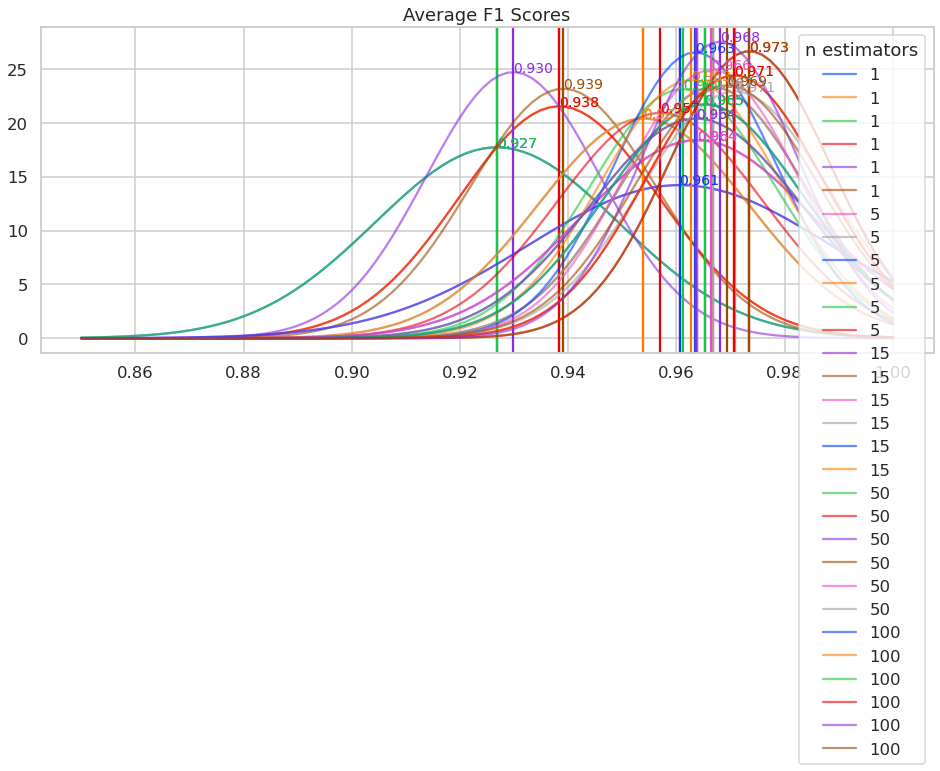

In [18]:
from scipy.stats import norm

def plot_some_tune_results(df):
    fig, ax = plt.subplots(1, 1, figsize=(16,6))
    x = np.linspace(0.85, 1.0, 100)

    n_estimators = df['config/randomforestclassifier__n_estimators'].values.tolist()

    lines = []
    for mu, sigma in zip(df['mean_f1_score'], df['std_f1_score']):
        pdf = norm.pdf(x, mu, sigma)
        line, = ax.plot(x, pdf, alpha=0.6)
        ax.axvline(mu, color=line.get_color())
        ax.text(mu, pdf.max(), f"{mu:.3f}", color=line.get_color(), fontsize=14)
        lines.append(line)

    plt.legend(handles=lines, labels=n_estimators, title="n estimators")
    ax.set_title(f"Average F1 Scores")
    
plot_some_tune_results(df)

## Really increase the size of the search space

In [15]:
#
# 6D search space - 960 combinations - 4800 calls to fit
#

ray_tuning_config = {
    'randomforestclassifier__n_estimators': tune.grid_search([1,5,15,50,100]),
    'randomforestclassifier__criterion': tune.grid_search(['gini', 'entropy']),
    'randomforestclassifier__max_features': tune.grid_search(['auto', 'sqrt', 'log2']),
#     'randomforestclassifier__bootstrap': tune.grid_search([True, False]),
#     'randomforestclassifier__min_samples_leaf': tune.grid_search([1,2,3,4]),
    'randomforestclassifier__min_samples_split': tune.grid_search([3,4,5,6])
}

In [16]:
analysis = tune.run(
                e2e_simple_training,
                config=ray_tuning_config,
                resources_per_trial=dict(cpu=1, gpu=0)
                )

Trial name,status,loc,randomforestclassifier__criterion,randomforestclassifier__max_features,randomforestclassifier__min_samples_split,randomforestclassifier__n_estimators
e2e_simple_training_00001,PENDING,,entropy,auto,3,1
e2e_simple_training_00002,PENDING,,gini,sqrt,3,1
e2e_simple_training_00003,PENDING,,entropy,sqrt,3,1
e2e_simple_training_00004,PENDING,,gini,log2,3,1
e2e_simple_training_00005,PENDING,,entropy,log2,3,1
e2e_simple_training_00006,PENDING,,gini,auto,4,1
e2e_simple_training_00007,PENDING,,entropy,auto,4,1
e2e_simple_training_00008,PENDING,,gini,sqrt,4,1
e2e_simple_training_00009,PENDING,,entropy,sqrt,4,1
e2e_simple_training_00010,PENDING,,gini,log2,4,1


(pid=128020) 2020-06-12 10:08:15,063	INFO trainable.py:217 -- Getting current IP.
Result for e2e_simple_training_00000:
  date: 2020-06-12_10-08-15
  done: true
  experiment_id: 07b207e1a2bc413b97a04ac77f19b40e
  experiment_tag: 0_randomforestclassifier__criterion=gini,randomforestclassifier__max_features=auto,randomforestclassifier__min_samples_split=3,randomforestclassifier__n_estimators=1
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.9191934661526313
  node_ip: 192.168.1.39
  pid: 128020
  std_f1_score: 0.02643794578779962
  time_since_restore: 0.09635472297668457
  time_this_iter_s: 0.09635472297668457
  time_total_s: 0.09635472297668457
  timestamp: 1591952895
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00000'
  
(pid=127973) 2020-06-12 10:08:15,157	INFO trainable.py:217 -- Getting current IP.
(pid=127992) 2020-06-12 10:08:15,161	INFO trainable.py:217 -- Getting current IP.
(pid=127965) 2020-06-12 10:08:15,234	INFO trainable.py:217 --

Result for e2e_simple_training_00013:
  date: 2020-06-12_10-08-17
  done: true
  experiment_id: e9e62f36ae3b4511a4882a9853f9bebc
  experiment_tag: 13_randomforestclassifier__criterion=entropy,randomforestclassifier__max_features=auto,randomforestclassifier__min_samples_split=5,randomforestclassifier__n_estimators=1
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.939731748193722
  node_ip: 192.168.1.39
  pid: 128254
  std_f1_score: 0.02000246884918496
  time_since_restore: 0.10946846008300781
  time_this_iter_s: 0.10946846008300781
  time_total_s: 0.10946846008300781
  timestamp: 1591952897
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00013'
  
Result for e2e_simple_training_00011:
  date: 2020-06-12_10-08-17
  done: true
  experiment_id: f2ca27ca60294614be3c9d476c3290d5
  experiment_tag: 11_randomforestclassifier__criterion=entropy,randomforestclassifier__max_features=log2,randomforestclassifier__min_samples_split=4,randomforestclassifier__n_

(pid=128289) 2020-06-12 10:08:18,772	INFO trainable.py:217 -- Getting current IP.
Result for e2e_simple_training_00023:
  date: 2020-06-12_10-08-18
  done: true
  experiment_id: 6ee467c31e5c4f3db9b99160657f8752
  experiment_tag: 23_randomforestclassifier__criterion=entropy,randomforestclassifier__max_features=log2,randomforestclassifier__min_samples_split=6,randomforestclassifier__n_estimators=1
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.9308794328789493
  node_ip: 192.168.1.39
  pid: 128322
  std_f1_score: 0.024710941570843113
  time_since_restore: 0.1919090747833252
  time_this_iter_s: 0.1919090747833252
  time_total_s: 0.1919090747833252
  timestamp: 1591952898
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00023'
  
Result for e2e_simple_training_00025:
  date: 2020-06-12_10-08-18
  done: true
  experiment_id: d0d856b8127f411ca1bc94767628ea49
  experiment_tag: 25_randomforestclassifier__criterion=entropy,randomforestclassifier__max_fea

Trial name,status,loc,randomforestclassifier__criterion,randomforestclassifier__max_features,randomforestclassifier__min_samples_split,randomforestclassifier__n_estimators,iter,total time (s)
e2e_simple_training_00037,PENDING,,entropy,auto,5,5,,
e2e_simple_training_00038,PENDING,,gini,sqrt,5,5,,
e2e_simple_training_00039,PENDING,,entropy,sqrt,5,5,,
e2e_simple_training_00040,PENDING,,gini,log2,5,5,,
e2e_simple_training_00041,PENDING,,entropy,log2,5,5,,
e2e_simple_training_00042,PENDING,,gini,auto,6,5,,
e2e_simple_training_00043,PENDING,,entropy,auto,6,5,,
e2e_simple_training_00028,RUNNING,,gini,log2,3,5,,
e2e_simple_training_00029,RUNNING,,entropy,log2,3,5,,
e2e_simple_training_00030,RUNNING,,gini,auto,4,5,,


(pid=128494) 2020-06-12 10:08:19,560	INFO trainable.py:217 -- Getting current IP.
(pid=128501) 2020-06-12 10:08:19,582	INFO trainable.py:217 -- Getting current IP.
Result for e2e_simple_training_00028:
  date: 2020-06-12_10-08-19
  done: true
  experiment_id: 12c3c89710f143cfb1d99544b532b637
  experiment_tag: 28_randomforestclassifier__criterion=gini,randomforestclassifier__max_features=log2,randomforestclassifier__min_samples_split=3,randomforestclassifier__n_estimators=5
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.9591790336909327
  node_ip: 192.168.1.39
  pid: 128498
  std_f1_score: 0.02092429172463977
  time_since_restore: 0.13657164573669434
  time_this_iter_s: 0.13657164573669434
  time_total_s: 0.13657164573669434
  timestamp: 1591952899
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 00028
  
(pid=128500) 2020-06-12 10:08:19,642	INFO trainable.py:217 -- Getting current IP.
Result for e2e_simple_training_00029:
  date: 2020-06-12_10-08

(pid=128677) 2020-06-12 10:08:21,605	INFO trainable.py:217 -- Getting current IP.
(pid=128662) 2020-06-12 10:08:21,592	INFO trainable.py:217 -- Getting current IP.
(pid=128669) 2020-06-12 10:08:21,642	INFO trainable.py:217 -- Getting current IP.
(pid=128671) 2020-06-12 10:08:21,669	INFO trainable.py:217 -- Getting current IP.
Result for e2e_simple_training_00040:
  date: 2020-06-12_10-08-21
  done: true
  experiment_id: 6e2c78bfa54e40b68a3b42d8a285efb3
  experiment_tag: 40_randomforestclassifier__criterion=gini,randomforestclassifier__max_features=log2,randomforestclassifier__min_samples_split=5,randomforestclassifier__n_estimators=5
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.9607087093293923
  node_ip: 192.168.1.39
  pid: 128662
  std_f1_score: 0.017027602256952563
  time_since_restore: 0.13191866874694824
  time_this_iter_s: 0.13191866874694824
  time_total_s: 0.13191866874694824
  timestamp: 1591952901
  timesteps_since_restore: 0
  training_iteration: 0


(pid=128715) 2020-06-12 10:08:23,066	INFO trainable.py:217 -- Getting current IP.
(pid=128706) 2020-06-12 10:08:23,053	INFO trainable.py:217 -- Getting current IP.
Result for e2e_simple_training_00050:
  date: 2020-06-12_10-08-23
  done: true
  experiment_id: 618ae99e158a468f9064ce45c06d9a37
  experiment_tag: 50_randomforestclassifier__criterion=gini,randomforestclassifier__max_features=sqrt,randomforestclassifier__min_samples_split=3,randomforestclassifier__n_estimators=15
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.9652052066845902
  node_ip: 192.168.1.39
  pid: 128763
  std_f1_score: 0.02686377871669072
  time_since_restore: 0.3648693561553955
  time_this_iter_s: 0.3648693561553955
  time_total_s: 0.3648693561553955
  timestamp: 1591952903
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00050'
  
Result for e2e_simple_training_00049:
  date: 2020-06-12_10-08-23
  done: true
  experiment_id: 0f627bd08e86436287631646374c8b38
  experiment_ta

2020-06-12 10:08:23,655	WARNING import_thread.py:126 -- The actor 'WrappedTrackFunc' has been exported 100 times. It's possible that this warning is accidental, but this may indicate that the same remote function is being defined repeatedly from within many tasks and exported to all of the workers. This can be a performance issue and can be resolved by defining the remote function on the driver instead. See https://github.com/ray-project/ray/issues/6240 for more discussion.


Result for e2e_simple_training_00055:
  date: 2020-06-12_10-08-23
  done: true
  experiment_id: dd59234dbd724e79baaefddd20e49063
  experiment_tag: 55_randomforestclassifier__criterion=entropy,randomforestclassifier__max_features=auto,randomforestclassifier__min_samples_split=4,randomforestclassifier__n_estimators=15
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.9665030082007025
  node_ip: 192.168.1.39
  pid: 128715
  std_f1_score: 0.018686235687365303
  time_since_restore: 0.38868284225463867
  time_this_iter_s: 0.38868284225463867
  time_total_s: 0.38868284225463867
  timestamp: 1591952903
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00055'
  
Result for e2e_simple_training_00054:
  date: 2020-06-12_10-08-23
  done: true
  experiment_id: 13516ed7ffc24a29a55b3d6d9cd663e6
  experiment_tag: 54_randomforestclassifier__criterion=gini,randomforestclassifier__max_features=auto,randomforestclassifier__min_samples_split=4,randomforestclassifier__n_

Trial name,status,loc,randomforestclassifier__criterion,randomforestclassifier__max_features,randomforestclassifier__min_samples_split,randomforestclassifier__n_estimators,iter,total time (s)
e2e_simple_training_00070,PENDING,,gini,log2,6,15,,
e2e_simple_training_00071,PENDING,,entropy,log2,6,15,,
e2e_simple_training_00072,PENDING,,gini,auto,3,50,,
e2e_simple_training_00073,PENDING,,entropy,auto,3,50,,
e2e_simple_training_00074,PENDING,,gini,sqrt,3,50,,
e2e_simple_training_00075,PENDING,,entropy,sqrt,3,50,,
e2e_simple_training_00076,PENDING,,gini,log2,3,50,,
e2e_simple_training_00060,RUNNING,,gini,auto,5,15,,
e2e_simple_training_00061,RUNNING,,entropy,auto,5,15,,
e2e_simple_training_00062,RUNNING,,gini,sqrt,5,15,,


Result for e2e_simple_training_00060:
  date: 2020-06-12_10-08-24
  done: true
  experiment_id: 0d9a8f64e86a4fac9232c1db90ff40bd
  experiment_tag: 60_randomforestclassifier__criterion=gini,randomforestclassifier__max_features=auto,randomforestclassifier__min_samples_split=5,randomforestclassifier__n_estimators=15
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.9665237562800352
  node_ip: 192.168.1.39
  pid: 128910
  std_f1_score: 0.025192518924377377
  time_since_restore: 0.31496500968933105
  time_this_iter_s: 0.31496500968933105
  time_total_s: 0.31496500968933105
  timestamp: 1591952904
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00060'
  
(pid=128903) 2020-06-12 10:08:24,655	INFO trainable.py:217 -- Getting current IP.
Result for e2e_simple_training_00062:
  date: 2020-06-12_10-08-24
  done: true
  experiment_id: cb01b73f384e4c61839304dc5cb90964
  experiment_tag: 62_randomforestclassifier__criterion=gini,randomforestclassifier__max_featu

(pid=129134) 2020-06-12 10:08:27,097	INFO trainable.py:217 -- Getting current IP.
Result for e2e_simple_training_00074:
  date: 2020-06-12_10-08-27
  done: true
  experiment_id: cee097634a504c0ea0d37ff22bbe53d5
  experiment_tag: 74_randomforestclassifier__criterion=gini,randomforestclassifier__max_features=sqrt,randomforestclassifier__min_samples_split=3,randomforestclassifier__n_estimators=50
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.9679577666950179
  node_ip: 192.168.1.39
  pid: 129074
  std_f1_score: 0.017895888057501218
  time_since_restore: 0.6891281604766846
  time_this_iter_s: 0.6891281604766846
  time_total_s: 0.6891281604766846
  timestamp: 1591952907
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00074'
  
Result for e2e_simple_training_00072:
  date: 2020-06-12_10-08-27
  done: true
  experiment_id: c44ffd1f6be44f16b8446ad942abf9df
  experiment_tag: 72_randomforestclassifier__criterion=gini,randomforestclassifier__max_features

(pid=129312) 2020-06-12 10:08:29,366	INFO trainable.py:217 -- Getting current IP.
(pid=129311) 2020-06-12 10:08:29,415	INFO trainable.py:217 -- Getting current IP.
Result for e2e_simple_training_00084:
  date: 2020-06-12_10-08-29
  done: true
  experiment_id: 51e77e185cac4bcd9b87b86bbe7e4b6a
  experiment_tag: 84_randomforestclassifier__criterion=gini,randomforestclassifier__max_features=auto,randomforestclassifier__min_samples_split=5,randomforestclassifier__n_estimators=50
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.9708149095521608
  node_ip: 192.168.1.39
  pid: 129085
  std_f1_score: 0.01930670972737523
  time_since_restore: 0.9107048511505127
  time_this_iter_s: 0.9107048511505127
  time_total_s: 0.9107048511505127
  timestamp: 1591952909
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 00084
  
(pid=129319) 2020-06-12 10:08:29,598	INFO trainable.py:217 -- Getting current IP.
(pid=129328) 2020-06-12 10:08:29,732	INFO trainable.py:217 -- Ge

Trial name,status,loc,randomforestclassifier__criterion,randomforestclassifier__max_features,randomforestclassifier__min_samples_split,randomforestclassifier__n_estimators,iter,total time (s)
e2e_simple_training_00095,PENDING,,entropy,log2,6,50,,
e2e_simple_training_00096,PENDING,,gini,auto,3,100,,
e2e_simple_training_00097,PENDING,,entropy,auto,3,100,,
e2e_simple_training_00098,PENDING,,gini,sqrt,3,100,,
e2e_simple_training_00099,PENDING,,entropy,sqrt,3,100,,
e2e_simple_training_00100,PENDING,,gini,log2,3,100,,
e2e_simple_training_00101,PENDING,,entropy,log2,3,100,,
e2e_simple_training_00086,RUNNING,,gini,sqrt,5,50,,
e2e_simple_training_00087,RUNNING,,entropy,sqrt,5,50,,
e2e_simple_training_00088,RUNNING,,gini,log2,5,50,,


Result for e2e_simple_training_00087:
  date: 2020-06-12_10-08-30
  done: true
  experiment_id: 37b2bc4dd8ad455dbce97c523b6bf78f
  experiment_tag: 87_randomforestclassifier__criterion=entropy,randomforestclassifier__max_features=sqrt,randomforestclassifier__min_samples_split=5,randomforestclassifier__n_estimators=50
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.9706422678005306
  node_ip: 192.168.1.39
  pid: 129312
  std_f1_score: 0.014948948966687818
  time_since_restore: 0.7848880290985107
  time_this_iter_s: 0.7848880290985107
  time_total_s: 0.7848880290985107
  timestamp: 1591952910
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 00087
  
(pid=129354) 2020-06-12 10:08:30,159	INFO trainable.py:217 -- Getting current IP.
Result for e2e_simple_training_00086:
  date: 2020-06-12_10-08-30
  done: true
  experiment_id: 1105fa61bdb743aca3dfb0d0d9f332f1
  experiment_tag: 86_randomforestclassifier__criterion=gini,randomforestclassifier__max_feature

(pid=129559) 2020-06-12 10:08:33,169	INFO trainable.py:217 -- Getting current IP.
Result for e2e_simple_training_00098:
  date: 2020-06-12_10-08-33
  done: true
  experiment_id: 1aedd81a1d394153869970067f668d20
  experiment_tag: 98_randomforestclassifier__criterion=gini,randomforestclassifier__max_features=sqrt,randomforestclassifier__min_samples_split=3,randomforestclassifier__n_estimators=100
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.9666967285720904
  node_ip: 192.168.1.39
  pid: 129481
  std_f1_score: 0.017256958288932766
  time_since_restore: 1.2684006690979004
  time_this_iter_s: 1.2684006690979004
  time_total_s: 1.2684006690979004
  timestamp: 1591952913
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 00098
  
Result for e2e_simple_training_00102:
  date: 2020-06-12_10-08-33
  done: true
  experiment_id: 4567ab9494584e59b3801b66ab062074
  experiment_tag: 102_randomforestclassifier__criterion=gini,randomforestclassifier__max_features

Trial name,status,loc,randomforestclassifier__criterion,randomforestclassifier__max_features,randomforestclassifier__min_samples_split,randomforestclassifier__n_estimators,iter,total time (s)
e2e_simple_training_00115,PENDING,,entropy,auto,6,100,,
e2e_simple_training_00116,PENDING,,gini,sqrt,6,100,,
e2e_simple_training_00117,PENDING,,entropy,sqrt,6,100,,
e2e_simple_training_00118,PENDING,,gini,log2,6,100,,
e2e_simple_training_00119,PENDING,,entropy,log2,6,100,,
e2e_simple_training_00106,RUNNING,,gini,log2,4,100,,
e2e_simple_training_00107,RUNNING,,entropy,log2,4,100,,
e2e_simple_training_00108,RUNNING,,gini,auto,5,100,,
e2e_simple_training_00109,RUNNING,,entropy,auto,5,100,,
e2e_simple_training_00110,RUNNING,,gini,sqrt,5,100,,


Result for e2e_simple_training_00106:
  date: 2020-06-12_10-08-35
  done: true
  experiment_id: b6d8825e24374342806d17bfeeea2eef
  experiment_tag: 106_randomforestclassifier__criterion=gini,randomforestclassifier__max_features=log2,randomforestclassifier__min_samples_split=4,randomforestclassifier__n_estimators=100
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.9693421883228087
  node_ip: 192.168.1.39
  pid: 129536
  std_f1_score: 0.015728923260512128
  time_since_restore: 1.5977375507354736
  time_this_iter_s: 1.5977375507354736
  time_total_s: 1.5977375507354736
  timestamp: 1591952915
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00106'
  
(pid=129692) 2020-06-12 10:08:35,413	INFO trainable.py:217 -- Getting current IP.
(pid=129689) 2020-06-12 10:08:35,606	INFO trainable.py:217 -- Getting current IP.
(pid=129694) 2020-06-12 10:08:35,612	INFO trainable.py:217 -- Getting current IP.
Result for e2e_simple_training_00107:
  date: 2020-06-12_10

Result for e2e_simple_training_00118:
  date: 2020-06-12_10-08-37
  done: true
  experiment_id: 0e2f054a4abe4249ba7a0c38d94b91d9
  experiment_tag: 118_randomforestclassifier__criterion=gini,randomforestclassifier__max_features=log2,randomforestclassifier__min_samples_split=6,randomforestclassifier__n_estimators=100
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.9679820350661037
  node_ip: 192.168.1.39
  pid: 129701
  std_f1_score: 0.014463142278844264
  time_since_restore: 0.958528995513916
  time_this_iter_s: 0.958528995513916
  time_total_s: 0.958528995513916
  timestamp: 1591952917
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 00118
  
Result for e2e_simple_training_00119:
  date: 2020-06-12_10-08-37
  done: true
  experiment_id: 8ba52cf4b9b54c4d9b04247cb2a33161
  experiment_tag: 119_randomforestclassifier__criterion=entropy,randomforestclassifier__max_features=log2,randomforestclassifier__min_samples_split=6,randomforestclassifier__n_estim

Trial name,status,loc,randomforestclassifier__criterion,randomforestclassifier__max_features,randomforestclassifier__min_samples_split,randomforestclassifier__n_estimators,iter,total time (s)
e2e_simple_training_00000,TERMINATED,,gini,auto,3,1,0,0.0963547
e2e_simple_training_00001,TERMINATED,,entropy,auto,3,1,0,0.129088
e2e_simple_training_00002,TERMINATED,,gini,sqrt,3,1,0,0.10347
e2e_simple_training_00003,TERMINATED,,entropy,sqrt,3,1,0,0.105589
e2e_simple_training_00004,TERMINATED,,gini,log2,3,1,0,0.19558
e2e_simple_training_00005,TERMINATED,,entropy,log2,3,1,0,0.204244
e2e_simple_training_00006,TERMINATED,,gini,auto,4,1,0,0.117187
e2e_simple_training_00007,TERMINATED,,entropy,auto,4,1,0,0.122917
e2e_simple_training_00008,TERMINATED,,gini,sqrt,4,1,0,0.0996759
e2e_simple_training_00009,TERMINATED,,entropy,sqrt,4,1,0,0.147364


In [17]:
from pprint import pprint
print("Best config: ")
pprint(analysis.get_best_config(metric="mean_f1_score"))

Best config: 
{'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__min_samples_split': 5,
 'randomforestclassifier__n_estimators': 100}


In [19]:
df = analysis.dataframe()
top_n_df = df.nlargest(10, "mean_f1_score")

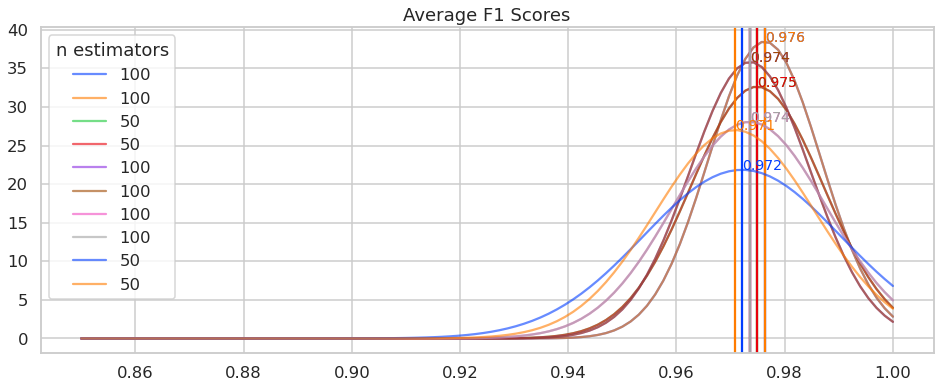

In [20]:
plot_some_tune_results(top_n_df)

In [21]:
%load_ext tensorboard

In [22]:
from tensorboard import notebook
%tensorboard --logdir "~/ray_results/grid_search"
notebook.display(height=1000) 

Reusing TensorBoard on port 6006 (pid 56090), started 21:56:01 ago. (Use '!kill 56090' to kill it.)

Selecting TensorBoard with logdir ~/ray_results/seg_facies (started 21:22:04 ago; port 6007, pid 59692).


### Once you are all done, shutdown Ray

In [23]:
ray.shutdown()